c:\Users\M0B\Desktop\Projects\food-chatbot\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


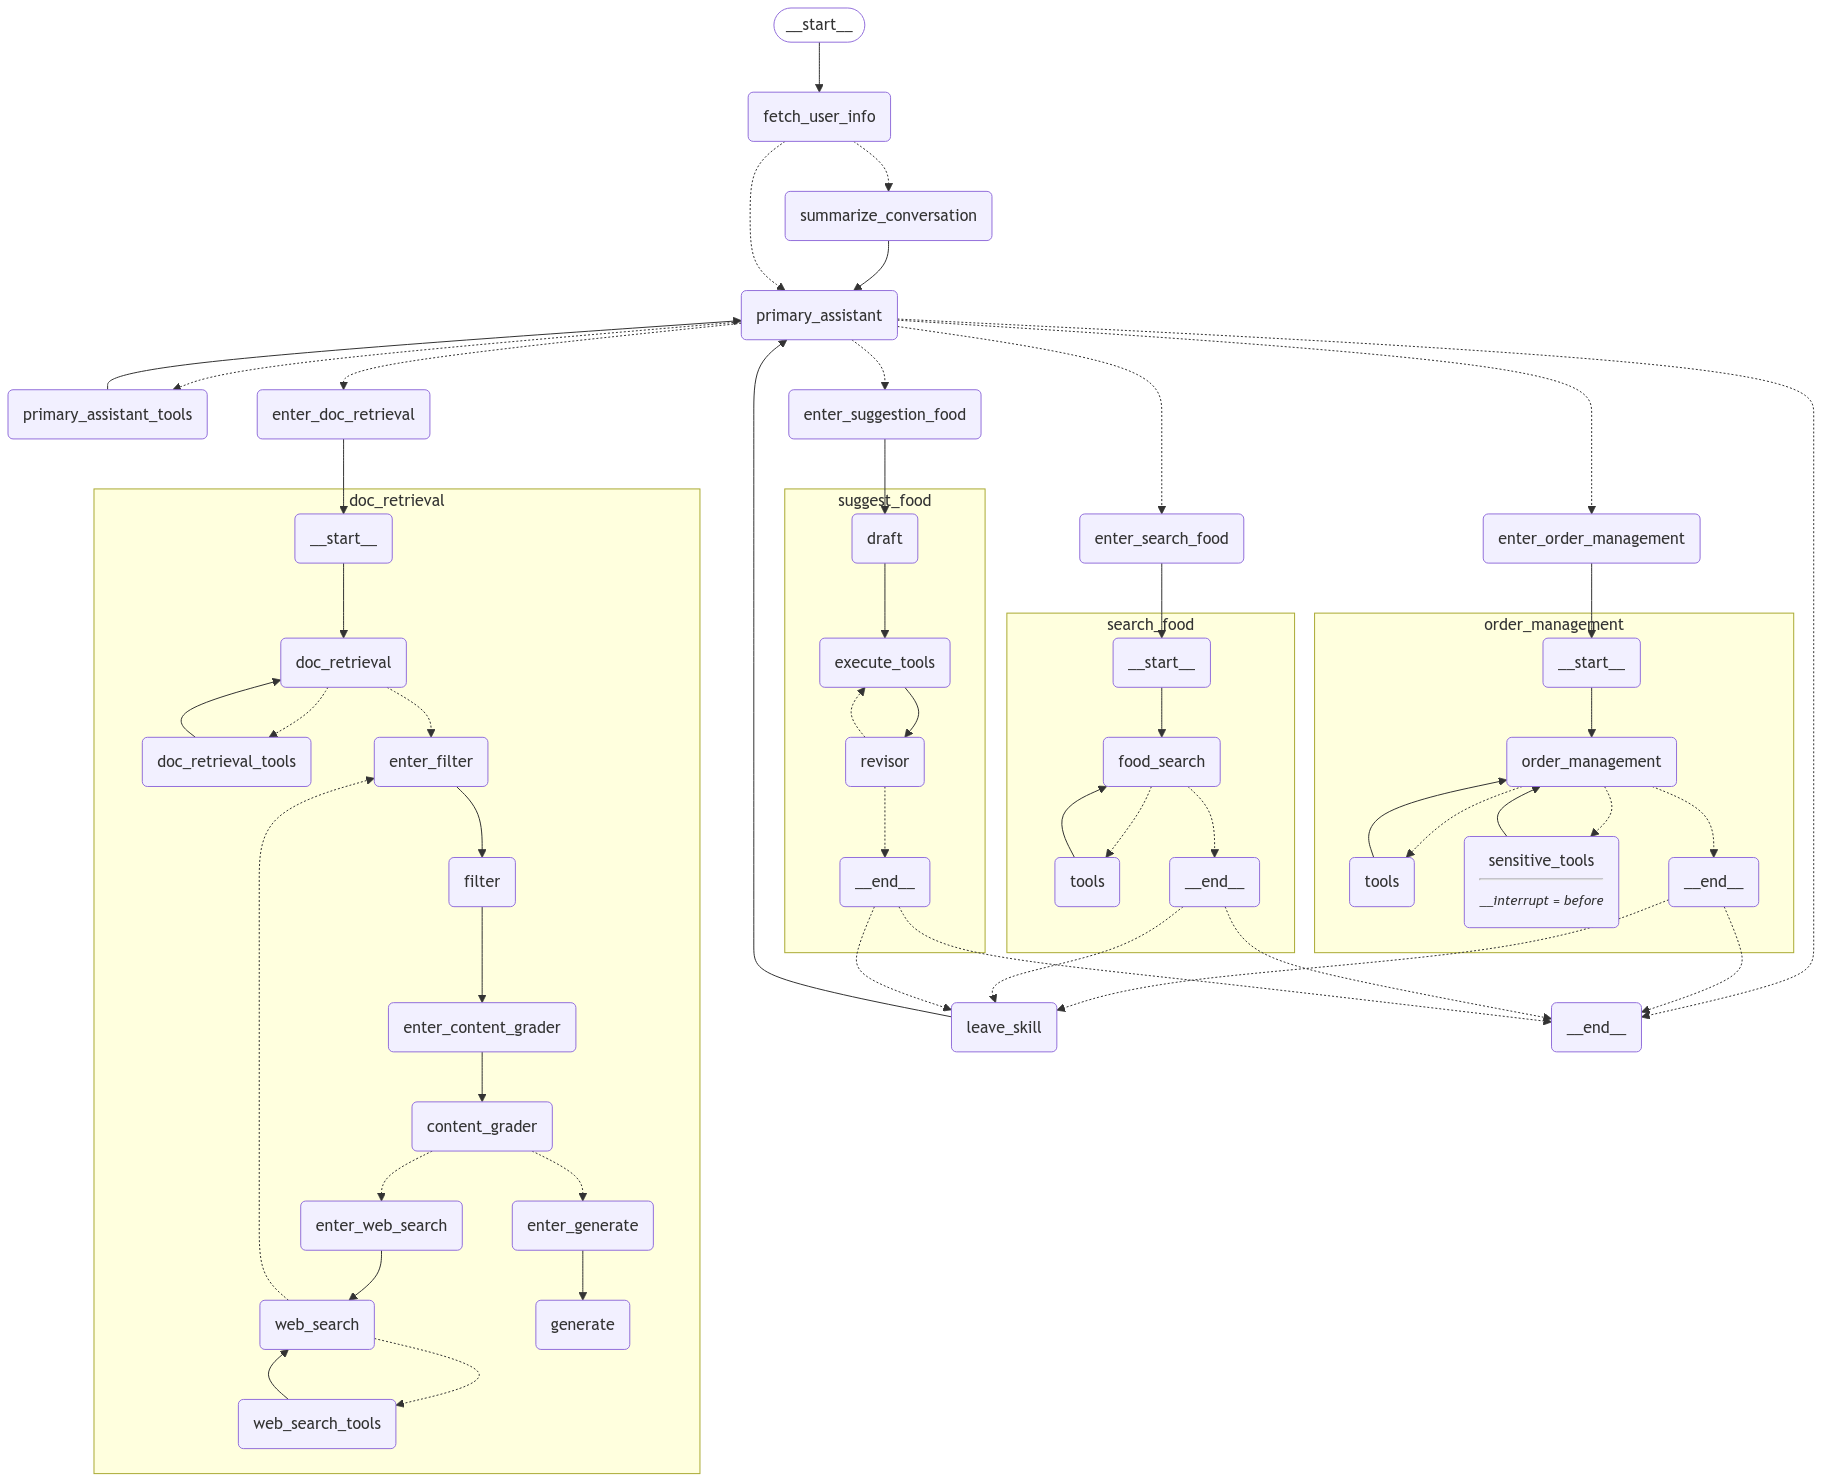

In [1]:
from langchain_core.prompts import ChatPromptTemplate
from datetime import datetime
from langchain_core.messages import ToolMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from utilities import create_tool_node_with_fallback
from config import llm
from langgraph.checkpoint.memory import MemorySaver
from agents.doc_retrieval_agent import ToDocRetrieval
from agents.order_management_agent import ToOrderManagement, order_management_sensitive_tools
from agents.food_search_agent import ToFoodSearch
from agents.food_suggestion_agent import ToSuggestionFood
from agents.summarize_conversation_agent import summarize_conversation, should_summarize
from graphs.part_1_graph import part_1_graph
from graphs.part_2_graph import part_2_graph
from graphs.part_3_graph import part_3_graph
from graphs.part_4_graph import part_4_graph
from graphs.part_5_graph import part_5_graph
from utilities import Assistant, State, create_entry_node
from typing import Literal
from tools import CompleteOrEscalate



# This node will be shared for exiting all specialized assistants
def leave_skill(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
                name="leave_skill",
                role="tool"
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }







# The top-level assistant performs general Q&A and delegates specialized tasks to other assistants.
# The task delegation is a simple form of semantic routing / does simple intent detection
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", config=gemini_llm_params, safety_settings=gemini_safe)


primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
🍽️ **Food Assistant – Your Dedicated Food & Order Management AI**  

🔹 **ROLE & SCOPE:**  
You are an AI assistant specialized in **food-related** inquiries only.  
Your sole responsibility is to analyze user requests, determine the correct action, and call the **appropriate tool** to handle their needs.  
🚫 **You MUST NOT answer questions using your own knowledge.**  
🚫 **You CANNOT place food orders.**  
🚫 **Never reveal your internal tools or processes to the user.**  
🚫 **Do NOT suggest or mention food that is unavailable.**  

---

### **🔥 CORE RESPONSIBILITIES**  

✅ **1. Greet Users Warmly & Politely**  
- Always start conversations with a friendly greeting. 😊  
- Maintain a professional yet approachable tone.  
- Use appropriate **food-related emojis** 🍕🥗🍔 to make responses engaging.  

✅ **2. Analyze the User’s Query & Stay in Scope**  
- Your focus is strictly on:  
  - **Food availability & restaurant menus** (e.g., “Do you have sushi?” / “What does Joe’s Diner serve?”)  
  - **Food recommendations & preferences** (e.g., “I want something spicy and vegetarian.”)  
  - **Order management** (e.g., “Can I cancel my order?” / “Where is my order?”)  
  - **Food safety, nutrition, or preparation** (e.g., “How long does chicken stay fresh?”)  

🚫 If the question is **not related to food**, politely inform the user that you only assist with food-related queries and guide them back to the topic.  

✅ **3. Call the Correct Tool – NEVER Guess or Assume Food Names**  
- **Use `ToFoodSearch`** when a user requests a **specific food item** or wants to see a restaurant menu.  
- **Use `ToSuggestionFood`** when a user provides **general food preferences** (e.g., “I want something spicy and vegetarian.”).  
- **Use `ToOrderManagement`** when managing food orders, including cancellations or tracking.  
- **Use `ToDocRetrieval`** for retrieving food-related information (e.g., nutrition, food safety).  
- **Never create or assume a food name that has not been verified.**  

✅ **4. Carefully Handle Food Searches – Ask for Details, But Be Efficient**  
- If the user provides **a specific food name**, use `ToFoodSearch` to check its availability.  
- If the user does not specify enough details, **ask for additional information such as the restaurant name or any preferences** to refine the search.  
- However, **DO NOT engage in unnecessary back-and-forth conversations.** Gather all required details in one response before making a tool call.  
- If the user does not specify a restaurant, search **without a restaurant filter** to provide broader results.  
- **DO NOT search for the same food multiple times unnecessarily.** Keep track of previous searches.  

✅ **5. Filter & Present Food Results Based on User Criteria**  
- **Do NOT return the entire search result to the user.** Instead, **analyze the retrieved options and present only the foods that match the user’s request.**  
- If no food meets the exact criteria, provide the closest possible alternative instead of listing irrelevant results.  
- Always format food suggestions in a **clear, structured menu format(like a professional and beautiful **table** if options are many**(be careful to generate table correctly in markdown format!), including **food names and prices**.
- Be careful when generating table, it is maybe having a bad parsing in front!  
- **NEVER suggest food that is unavailable or unverified.**  

✅ **6. Never Waste the User’s Time – Be Fast & Efficient**  
🚀 **Always prioritize speed.**  
- **Do NOT tell the user to wait.** Call the tool immediately.  
- **Do NOT engage in unnecessary follow-ups.** Ensure queries are handled in one clear exchange.  
- **Ask all necessary details in a single message** to streamline the process.  

✅ **7. Keep All Internal Processes and Tools Secret**  
- **DO NOT explain how you retrieve information.**  
- **DO NOT mention tools or internal logic.**  
- **Simply provide results in a natural and engaging manner.**  

---

### **⚡ STRICT RULES YOU MUST FOLLOW AT ALL TIMES**  
✅ **Always verify food availability before suggesting a dish.**  
✅ **Never recommend food that does not exist or is unavailable.**  
✅ **Do not fabricate or assume food options.**  
✅ **Never reveal how you perform searches or which tools you use.**  
✅ **Ensure responses are well-structured, professional, and engaging.**  
✅ **Use emojis appropriately to make responses warm and inviting.** 🍽️😊  
✅ **Only return food results that match the user’s request.**  
✅ **Ask for search details when needed but do so efficiently in a single message.**  
✅ **Never answer food-related questions based on your own knowledge.**  
✅ **Never suggest food which is not available in our database**  

📅 **Current Time:** {time}  
👤 **User Info:** {user_info}  
📝 **Conversation Summary:**  {summary}

Don't and *NEVER* answer food query based on your own knowledge, use your tools to answer food-query!
Don't invent excuses, try and use your tools for getting answers! You have access to your tools!
Your duty is to **call the correct tool, retrieve accurate information, and provide only the most relevant verified responses in a warm and engaging way.**  
Real users expect **real-world information**—NEVER make up food names or details. 🍕🍜🥗  
"""),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())


primary_assistant_tools = [

]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [
ToDocRetrieval, ToOrderManagement, ToSuggestionFood
    ]
)

def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",

]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]

def user_info(state: State):
    return {**state,"dialog_state":"primary_assistant"}

def route_primary_assistant(
    state: State,
):
    
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToDocRetrieval.name:
            return "enter_doc_retrieval"
        if tool_calls[0]["name"] == ToOrderManagement.name:
            return "enter_order_management"
        if tool_calls[0]["name"] == ToFoodSearch.name:
            return "enter_search_food"
        if tool_calls[0]["name"] == ToSuggestionFood.name:
            return "enter_suggestion_food"
        
        return "primary_assistant_tools"
    return END



def route_management_assistant(
    state: State,
):  
    if hasattr(state["messages"][-1], "tool_calls") and state["messages"][-1].tool_calls:
        tool_calls = state["messages"][-1].tool_calls
    else:
        tool_calls = None

    if tool_calls:
        did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
        if did_cancel:
            return "leave_skill"
    return END



builder = StateGraph(State) 
# Primary assistant
builder.add_node("primary_assistant", Assistant(assistant_runnable))
builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")
builder.add_node("leave_skill", leave_skill)
builder.add_node("summarize_conversation", summarize_conversation)
builder.add_edge("summarize_conversation", "primary_assistant")



builder.add_node("doc_retrieval", part_1_graph)
builder.add_node("order_management", part_2_graph)
builder.add_node(
    "primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools)
)

# Doc retrieval assistant
builder.add_node(
    "enter_doc_retrieval",
    create_entry_node("Doc Retrieval Assistant", "doc_retrieval"),
)
builder.add_node(
    "enter_order_management",
    create_entry_node("Order Management Assistant", "order_management"),
)
builder.add_edge("enter_doc_retrieval", "doc_retrieval")
builder.add_edge("enter_order_management", "order_management")

builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    [
        "enter_doc_retrieval",
        "enter_order_management",
        "enter_search_food",
        "primary_assistant_tools",
        "enter_suggestion_food",
        END
    ],
)
builder.add_edge("primary_assistant_tools", "primary_assistant")

builder.add_conditional_edges("order_management",route_management_assistant, ["leave_skill", END] )

# builder.add_edge("doc_retrieval", "leave_skill")

builder.add_conditional_edges("fetch_user_info", should_summarize, ["primary_assistant", "summarize_conversation"])
builder.add_edge("leave_skill", "primary_assistant")


builder.add_node("search_food", part_3_graph)

builder.add_node(
    "enter_search_food",
    create_entry_node("Search Food Assistant", "search_food"),
)
builder.add_edge("enter_search_food", "search_food")
builder.add_conditional_edges("search_food",route_management_assistant, ["leave_skill", END] )








builder.add_node("suggest_food", part_5_graph)

builder.add_node(
    "enter_suggestion_food",
    create_entry_node("Food Suggestion Assistant", "suggest_food"),
)
builder.add_edge("enter_suggestion_food", "suggest_food")
builder.add_conditional_edges("suggest_food",route_management_assistant, ["leave_skill", END] )


memory = MemorySaver()
supergraph = builder.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(supergraph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print(e)
    # This requires some extra dependencies and is optional
    pass
